# ☕ BERT ด้วย PyTorch สำหรับวิเคราะห์รีวิวกาแฟ

ยินดีต้อนรับสู่บทเรียน PyTorch สำหรับการวิเคราะห์ความรู้สึกของรีวิวกาแฟด้วยโมเดล BERT! เราจะพาคุณเรียนรู้ตั้งแต่การโหลดข้อมูล เตรียมข้อความ ไปจนถึงการฝึกสอนและใช้งานโมเดล BERT บนรีวิวกาแฟจริงๆ

---

## 📘 บทนำ

**PyTorch** เป็นเฟรมเวิร์ก Deep Learning ยอดนิยมจาก Meta (Facebook) ที่ใช้งานง่าย ยืดหยุ่น และเหมาะกับการทดลองโมเดลเชิงลึก โดยเฉพาะบน GPU ซึ่งในบทเรียนนี้ เราจะใช้ PyTorch ร่วมกับ Transformers (BERT) เพื่อวิเคราะห์ความรู้สึกจากรีวิวกาแฟของผู้บริโภค
โมเดลที่เราเลือกใช้คือ **BERT (Bidirectional Encoder Representations from Transformers)** ซึ่งเป็นโมเดลภาษาเชิงลึกที่สามารถเข้าใจบริบทของคำในประโยคได้ทั้งสองทิศทาง ช่วยให้เข้าใจรีวิวที่มีภาษาซับซ้อน หรือคำบรรยายรสชาติได้อย่างแม่นยำ

### 🧾 เกี่ยวกับ Dataset รีวิวกาแฟ
[coffee_reviews.csv](https://drive.google.com/file/d/1r98qZTuVJPuIvpHyyoR5gWQcab8hAFeH/view?usp=sharing)

ชุดข้อมูลนี้รวบรวมรีวิวกาแฟจากผู้ชิมมืออาชีพ ซึ่งประกอบด้วยข้อมูลหลายมิติ ทั้งคำบรรยายรส กลิ่น เนื้อสัมผัส รวมถึงคะแนนประเมินโดยรวม

- 📝 คอลัมน์ข้อความรีวิว: เช่น "Blind Assessment", "Notes", "Bottom Line"
- 🌟 คะแนน (Rating): ใช้เป็นเกณฑ์ในการแปลงเป็น sentiment (positive/negative)  
- 🧠 เป้าหมายของเรา: สร้างโมเดลที่สามารถวิเคราะห์ข้อความรีวิว แล้วทำนายว่ารีวิวนั้นมี ความรู้สึกเชิงบวกหรือไม่

🎯 ชุดข้อมูลนี้เหมาะสำหรับการฝึกทำ NLP เบื้องต้น โดยเฉพาะการนำโมเดล BERT มาประยุกต์ใช้งานจริงกับรีวิวที่มีความหมายหลากหลาย
---

## 🛠️ ขั้นตอนที่ 1: เตรียมสภาพแวดล้อม (Environment Setup)

ก่อนเริ่มใช้งาน Jupyter Notebook และ PyTorch แนะนำให้สร้าง Python Environment แยกต่างหาก

### 🔹 1. สร้าง Virtual Environment
```bash
python -m venv env-pytorch
```

### 🔹 2. เปิดใช้งาน Environment
```bash
source env-pytorch/bin/activate
```

### 🔹 3. ติดตั้ง Library ที่จำเป็น
Download  [requirements.txt](https://drive.google.com/file/d/1cO6EV_sD_-zMkiADOr3hRwcdCTMSMIyJ/view?usp=sharing)
```bash
pip install -r requirements.txt
```

### 🔹 4. เพิ่ม Environment นี้ให้ Jupyter ใช้งาน
```bash
python -m ipykernel install --user --name=env-pytorch --display-name "Python (env-pytorch)"
```

---

## 🔄 ขั้นตอนที่ 2: เปิด Notebook และเลือก Kernel

เมื่อเปิด Jupyter Notebook แล้ว:

1. คลิกที่ชื่อ Kernel ปัจจุบัน (เช่น "Python 3") ที่มุมบนขวา
![ipykernel](kernel.png)

3. เลือก Kernel ที่ชื่อ "Python (env-pytorch)" (ตามที่ตั้งไว้ในขั้นตอนก่อน)
![select ](pythroch.png)
> 💡 หากยังไม่เห็นชื่อ Kernel นี้ ให้ลองปิด/เปิด Jupyter ใหม่ หรือเช็กคำสั่ง ipykernel อีกครั้ง

---

## 💻 ขั้นตอนที่ 3: เริ่มเขียนโค้ด PyTorch สำหรับ BERT

## 📥 Download data set coffee_reviews.csv
[coffee_reviews.csv](https://drive.google.com/file/d/1r98qZTuVJPuIvpHyyoR5gWQcab8hAFeH/view?usp=sharing)

## 📂 Cell 1: นำเข้าไลบรารีที่จำเป็น

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset, DataLoader 
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.nn.parallel import DataParallel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm
import torch.nn.functional as F


## 🔧 2. Device and Multi-GPU Setup


In [2]:
n_gpu = torch.cuda.device_count()
print(f"🖥️ Detected GPUs: {n_gpu}")

if n_gpu == 0:
    device = torch.device("cpu")
    print("⚠️ No GPU found. Using CPU instead.")
else:
    device = torch.device("cuda")
    print(f"✅ Using {n_gpu} GPU(s)")
    # Print GPU info
    for i in range(n_gpu):
        print(f"  - GPU {i}: {torch.cuda.get_device_name(i)}")


🖥️ Detected GPUs: 2
✅ Using 2 GPU(s)
  - GPU 0: Tesla V100-SXM2-32GB
  - GPU 1: Tesla V100-SXM2-32GB


## 📄 2. Load Coffee Dataset

In [3]:
data = pd.read_csv("coffee_reviews.csv")
print(f"📊 Dataset size: {len(data)} reviews")
print(f"📊 Columns: {data.columns.tolist()}")

# Use text and score columns
texts = data["Blind Assessment"].fillna("").tolist()
labels = (data["Final Score"] >= 85).astype(int).tolist() 

# Print class distribution
positive_count = sum(labels)
negative_count = len(labels) - positive_count
print(f"📊 Class distribution:")
print(f"  - Positive reviews (score >= 85): {positive_count} ({positive_count/len(labels)*100:.1f}%)")
print(f"  - Negative reviews (score < 85): {negative_count} ({negative_count/len(labels)*100:.1f}%)")

# Split train/test with stratification to ensure balanced classes
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.1, random_state=42, stratify=labels
)

print(f"📚 Training set: {len(train_texts)} samples")
print(f"📚 Validation set: {len(val_texts)} samples")

📊 Dataset size: 8327 reviews
📊 Columns: ['URL', 'Final Score', 'Roaster', 'Coffee Name', 'Roaster Location', 'Coffee Origin', 'Roast Level', 'Agtron', 'Est. Price', 'Review Date', 'Aroma', 'Acidity/Structure', 'Body', 'Flavor', 'Aftertaste', 'With Milk', 'Blind Assessment', 'Notes', 'Bottom Line']
📊 Class distribution:
  - Positive reviews (score >= 85): 7823 (93.9%)
  - Negative reviews (score < 85): 504 (6.1%)
📚 Training set: 7494 samples
📚 Validation set: 833 samples


## ✂️ 3. Create Dataset for BERT

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class CoffeeDataset(Dataset):
    def __init__(self, texts, labels):
        # Increase max_length to capture more text
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=256)
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = CoffeeDataset(train_texts, train_labels)
val_dataset = CoffeeDataset(val_texts, val_labels)

# Optimize batch size for multi-GPU
# For 2 GPUs, we need a larger total batch size
total_batch_size = 64 if n_gpu > 1 else 32  # Larger batch size for multi-GPU

# For DataParallel, we specify the total batch size
train_loader = DataLoader(
    train_dataset, 
    batch_size=total_batch_size, 
    shuffle=True,
    num_workers=4,  # Multiple workers for faster data loading
    pin_memory=True  # Speeds up data transfer to GPU
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=total_batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

## 🧱 4. Load BERT Model with Multi-GPU Support

In [5]:
print("🧠 Initializing BERT model...")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Note: This is normal for a classification head
print("⚠️ Note: It's normal for classifier.bias and classifier.weight to be newly initialized")
print("   as we've changed the number of classes from the original model.")

# Improved DataParallel setup
if n_gpu > 1:
    print(f"⚡ Using DataParallel to distribute model across {n_gpu} GPUs")
    # Set find_unused_parameters=False for better performance
    model = DataParallel(model)

# Move model to device
model.to(device)

🧠 Initializing BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


⚠️ Note: It's normal for classifier.bias and classifier.weight to be newly initialized
   as we've changed the number of classes from the original model.
⚡ Using DataParallel to distribute model across 2 GPUs


DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=7

## 🚀 5. Training

In [6]:
# Better optimizer settings
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)  # Added weight decay

# Add learning rate scheduler with warmup
num_epochs = 5  # Increased epochs
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.1 * total_steps)  # 10% warmup

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Mixed precision training
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

# Training tracking
best_val_f1 = 0
epoch_times = []
train_losses = []
val_losses = []
val_f1_scores = []

# Function for evaluation
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss
            
            # Fix for non-scalar loss with DataParallel
            if loss.dim() > 0:
                loss = loss.mean()
                
            logits = outputs.logits
            
            # Move predictions and labels to CPU to avoid CUDA tensor errors
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels)
            total_loss += loss.item()
    
    # Calculate metrics
    avg_loss = total_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds)
    
    return avg_loss, f1, all_preds, all_labels

# Main training loop
print(f"\n🚀 Starting training for {num_epochs} epochs...")
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    
    # Training phase
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch in progress_bar:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Clear previous gradients
        optimizer.zero_grad()
        
        # Forward pass with mixed precision
        with autocast():
            outputs = model(**batch)
            loss = outputs.loss
            
            # Fix for non-scalar loss with DataParallel
            if loss.dim() > 0:
                loss = loss.mean()  # Average loss across GPUs
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Update learning rate
        scheduler.step()
        
        # Update progress
        current_loss = loss.item()
        total_loss += current_loss
        progress_bar.set_postfix({"loss": f"{current_loss:.4f}"})
    
    # Calculate average training loss
    avg_train_loss = total_loss / len(train_loader)
    
    # Evaluation phase
    val_loss, val_f1, val_preds, val_labels = evaluate_model(model, val_loader)
    
    # Record metrics
    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    
    epoch_times.append(epoch_time)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)
    
    print(f"📊 Epoch {epoch+1}/{num_epochs} Summary:")
    print(f"  - Training Loss: {avg_train_loss:.4f}")
    print(f"  - Validation Loss: {val_loss:.4f}, F1 Score: {val_f1:.4f}")
    print(f"  - Time: {epoch_time:.2f} seconds")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        
        # Save model (handle both DataParallel and regular models)
        if isinstance(model, DataParallel):
            torch.save(model.module.state_dict(), "best_coffee_classifier.pt")
        else:
            torch.save(model.state_dict(), "best_coffee_classifier.pt")
        
        print(f"💾 New best model saved with F1: {val_f1:.4f}")

# Final evaluation
print("\n📈 Final Classification Report:")
print(classification_report(val_labels, val_preds, target_names=["Negative", "Positive"]))

/tmp/ipykernel_5853/3862884122.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



🚀 Starting training for 5 epochs...


Epoch 1/5:   0%|          | 0/118 [00:00<?, ?it/s]/tmp/ipykernel_5853/3862884122.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/jovyan/env-new/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Epoch 1/5: 100%|██████████| 118/118 [00:21<00:00,  5.62it/s, loss=0.0417]


📊 Epoch 1/5 Summary:
  - Training Loss: 0.3131
  - Validation Loss: 0.1221, F1 Score: 0.9738
  - Time: 23.14 seconds
💾 New best model saved with F1: 0.9738


Epoch 2/5:   0%|          | 0/118 [00:00<?, ?it/s]/tmp/ipykernel_5853/3862884122.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/jovyan/env-new/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Epoch 2/5: 100%|██████████| 118/118 [00:20<00:00,  5.82it/s, loss=0.4828]


📊 Epoch 2/5 Summary:
  - Training Loss: 0.1062
  - Validation Loss: 0.0799, F1 Score: 0.9783
  - Time: 22.34 seconds
💾 New best model saved with F1: 0.9783


Epoch 3/5:   0%|          | 0/118 [00:00<?, ?it/s]/tmp/ipykernel_5853/3862884122.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/jovyan/env-new/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Epoch 3/5: 100%|██████████| 118/118 [00:20<00:00,  5.83it/s, loss=0.0026]


📊 Epoch 3/5 Summary:
  - Training Loss: 0.0645
  - Validation Loss: 0.0748, F1 Score: 0.9848
  - Time: 22.31 seconds
💾 New best model saved with F1: 0.9848


Epoch 4/5:   0%|          | 0/118 [00:00<?, ?it/s]/tmp/ipykernel_5853/3862884122.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/jovyan/env-new/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Epoch 4/5: 100%|██████████| 118/118 [00:19<00:00,  5.91it/s, loss=0.2190]


📊 Epoch 4/5 Summary:
  - Training Loss: 0.0437
  - Validation Loss: 0.0681, F1 Score: 0.9853
  - Time: 22.05 seconds
💾 New best model saved with F1: 0.9853


Epoch 5/5:   0%|          | 0/118 [00:00<?, ?it/s]/tmp/ipykernel_5853/3862884122.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/jovyan/env-new/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Epoch 5/5: 100%|██████████| 118/118 [00:20<00:00,  5.82it/s, loss=0.0018]


📊 Epoch 5/5 Summary:
  - Training Loss: 0.0269
  - Validation Loss: 0.0710, F1 Score: 0.9866
  - Time: 22.35 seconds
💾 New best model saved with F1: 0.9866

📈 Final Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.80      0.79        50
    Positive       0.99      0.99      0.99       783

    accuracy                           0.97       833
   macro avg       0.89      0.89      0.89       833
weighted avg       0.98      0.97      0.97       833



## 📊 6. Create Visualizations

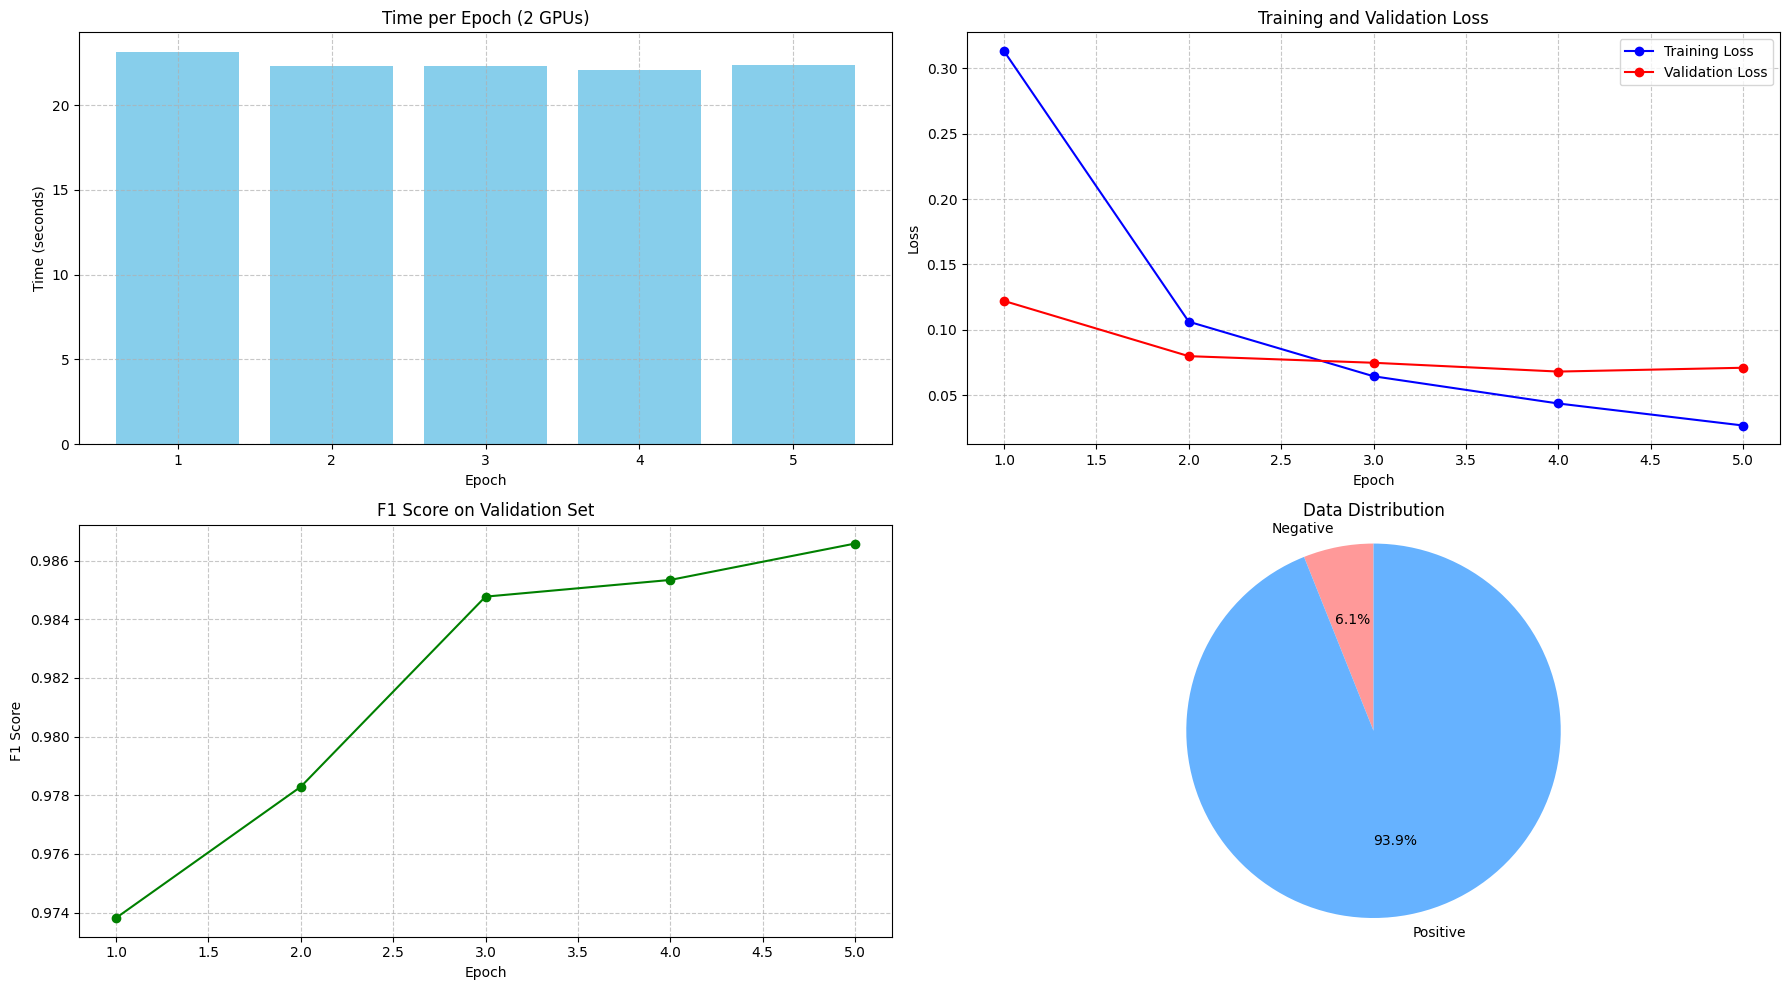

In [7]:
plt.figure(figsize=(18, 10))

# Time per epoch
plt.subplot(2, 2, 1)
plt.bar(range(1, num_epochs + 1), epoch_times, color='skyblue')
plt.title(f'Time per Epoch ({n_gpu} GPUs)')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.grid(True, linestyle='--', alpha=0.7)

# Loss curves
plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, 'o-', color='blue', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'o-', color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# F1 Score
plt.subplot(2, 2, 3)
plt.plot(range(1, num_epochs + 1), val_f1_scores, 'o-', color='green')
plt.title('F1 Score on Validation Set')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True, linestyle='--', alpha=0.7)

# Data distribution
plt.subplot(2, 2, 4)
# Ensure we're using standard Python types for plotting
positive_count = float(positive_count)
total_count = float(len(labels))
counts = [total_count - positive_count, positive_count]
classes = ['Negative', 'Positive']
colors = ['#FF9999', '#66B2FF']
plt.pie(counts, labels=classes, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Data Distribution')

plt.tight_layout()
plt.savefig(f'training_metrics_{n_gpu}_gpus.png')
plt.show()

## 🔍 7. Sample Predictions


🔍 Sample Predictions:
📝 Text: This coffee has a smooth, chocolatey flavor with hints of caramel.
🏷️ Prediction: Positive ✅
🔢 Confidence: 99.61%

📝 Text: Disappointing brew with sour notes and a bitter aftertaste.
🏷️ Prediction: Negative ❌
🔢 Confidence: 91.06%

📝 Text: The coffee exhibits a wonderful balance of acidity and sweetness with floral notes.
🏷️ Prediction: Positive ✅
🔢 Confidence: 99.17%

📝 Text: Weak flavor profile with minimal depth and an underwhelming finish.
🏷️ Prediction: Negative ❌
🔢 Confidence: 78.03%

📝 Text: Exceptional body with persisting notes of dark chocolate and a clean finish.
🏷️ Prediction: Positive ✅
🔢 Confidence: 99.76%

📝 Text: Unpleasant astringency dominates, with minimal sweetness and a harsh mouthfeel.
🏷️ Prediction: Negative ❌
🔢 Confidence: 94.73%



/tmp/ipykernel_5853/2086770497.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


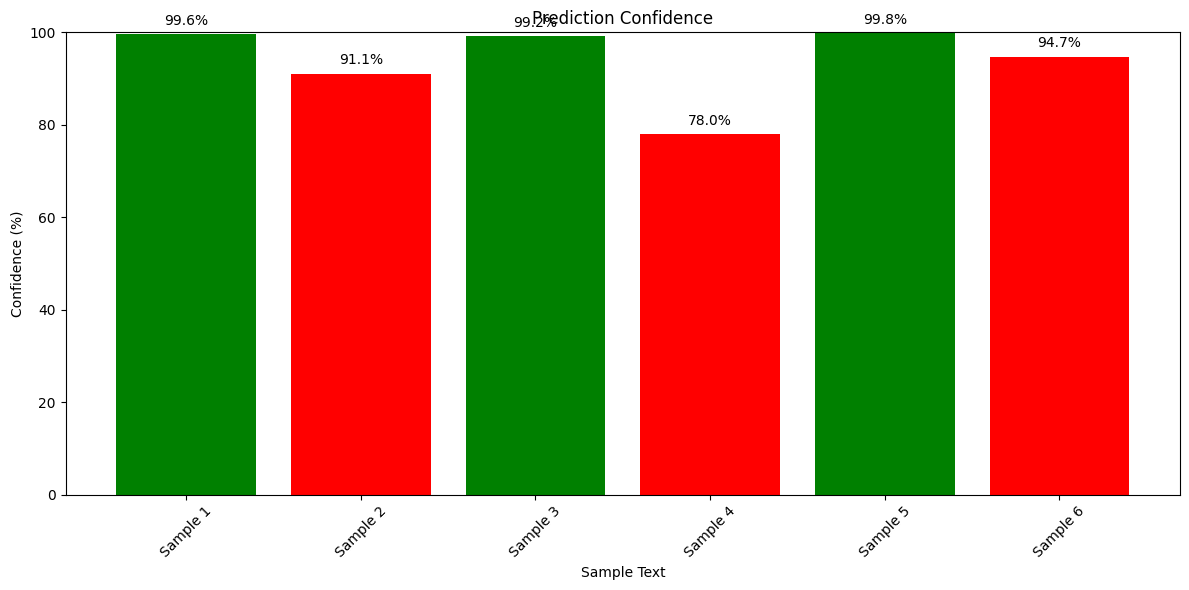

In [8]:
print("\n🔍 Sample Predictions:")
sample_texts = [
    "This coffee has a smooth, chocolatey flavor with hints of caramel.",
    "Disappointing brew with sour notes and a bitter aftertaste.",
    "The coffee exhibits a wonderful balance of acidity and sweetness with floral notes.",
    "Weak flavor profile with minimal depth and an underwhelming finish.",
    "Exceptional body with persisting notes of dark chocolate and a clean finish.",
    "Unpleasant astringency dominates, with minimal sweetness and a harsh mouthfeel."
]

# Get the base model if we're using DataParallel
prediction_model = model.module if isinstance(model, DataParallel) else model
prediction_model.eval()

predictions = []
confidence_scores = []

for text in sample_texts:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        with autocast():
            outputs = prediction_model(**inputs)
    
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    prediction = torch.argmax(logits, dim=-1).item()
    confidence = probs[0][prediction].item() * 100
    
    predictions.append(prediction)
    confidence_scores.append(float(confidence))
    
    print(f"📝 Text: {text}")
    print(f"🏷️ Prediction: {'Positive ✅' if prediction == 1 else 'Negative ❌'}")
    print(f"🔢 Confidence: {confidence:.2f}%\n")

# Create confidence visualization
plt.figure(figsize=(12, 6))
colors = ['red' if pred == 0 else 'green' for pred in predictions]

plt.bar(range(len(sample_texts)), confidence_scores, color=colors)
plt.xticks(range(len(sample_texts)), [f"Sample {i+1}" for i in range(len(sample_texts))], rotation=45)
plt.title('Prediction Confidence')
plt.xlabel('Sample Text')
plt.ylabel('Confidence (%)')
plt.ylim(0, 100)

for i, confidence in enumerate(confidence_scores):
    plt.text(i, confidence + 2, f"{confidence:.1f}%", ha='center')

plt.tight_layout()
plt.savefig('prediction_confidence.png')
plt.show()

## 💾 8. GPU Usage Analysis

In [9]:
print("\n🔍 GPU Utilization:")
for i in range(n_gpu):
    gpu_memory_allocated = torch.cuda.memory_allocated(i) / (1024 ** 3)  # GB
    gpu_memory_reserved = torch.cuda.memory_reserved(i) / (1024 ** 3)  # GB
    print(f"GPU {i}: Memory Allocated {gpu_memory_allocated:.2f} GB, Memory Reserved {gpu_memory_reserved:.2f} GB")

print("\n✅ Training complete!")
print(f"💾 Best model saved to best_coffee_classifier.pt with F1 score: {best_val_f1:.4f}")
print("📊 Check the generated visualizations for performance metrics.")


🔍 GPU Utilization:
GPU 0: Memory Allocated 1.68 GB, Memory Reserved 5.15 GB
GPU 1: Memory Allocated 0.02 GB, Memory Reserved 4.04 GB

✅ Training complete!
💾 Best model saved to best_coffee_classifier.pt with F1 score: 0.9866
📊 Check the generated visualizations for performance metrics.
